In [118]:
# Import our dependencies
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
import tensorflow as tf
import keras_tuner as kt
import pathlib
import random
import pandas as pd
import sys

from credentials import CONNECTION_INFO
from constants import *

import encoders
import db_connect
import helpers
import tf_helpers

# Callbacks for use with TensorFlow
from tf_helpers import modulo_output, modulo_distance_loss, modulo_distance_accuracy, modulo_rounded_accuracy, initialize_save_best

## Config
This notebook has a lot of options to adjust, most of which are controlled here.

In [132]:
ENCODER = encoders.ENCODER_CAESAR
CHUNK_SIZE = 512 # Was 512
PROCESSING_UNITS = CHUNK_SIZE // 16 # Was // 4

EXTRA_CHECKS = False # Whether to run some (potentially slow) debug checks

INFER_TEXT = False # Text inferrence isn't really working. I don't know how to combine the time-distributed results.
INFER_KEY = not INFER_TEXT

if INFER_TEXT:
    MAIN_ACCURACY_METRIC = "mae"
    LOSS_METRIC = "mean_squared_error"
    OUTPUT_SIZE = CHUNK_SIZE
    OPTIMIZER = "sgd"
else:
    MAIN_ACCURACY_METRIC = "mae"
    LOSS_METRIC = "mae"
    OPTIMIZER = "adamax"    

    if ENCODER == encoders.ENCODER_CAESAR:
        OUTPUT_SIZE = 1
    elif ENCODER == encoders.ENCODER_SUBST:
        OUTPUT_SIZE = len(encoders.CHARSET)
    else:
        raise Exception(f"Unsupported encoder {ENCODER}")

ENCRYPTED_FILE_LIMIT = -1 # -1 to disable limit

BASE_TRAIN_PCT = 0.75   # Start here. If train or test count would exceed the max, reduce it. Note 0.75 is the default.
MAX_TRAIN_COUNT = -1 # -1 to disable; some setups start running out of memory around 100K
MAX_TEST_COUNT =  -1 # -1 to disable
SPLIT_SEED = 42

LOAD_BEST_MODEL = False # If False, a new model will be created from scratch
SAVE_BEST_MODEL = True
BEST_PATH = './saved_models/best.keras'

# Whether to run the tuner or the hard-coded network build code
TUNE_NETWORK = False
TUNE_QUICKLY = False # Set True to sanity check the model builder
BUILD_NETWORK = not TUNE_NETWORK
TRAIN_MODEL = BUILD_NETWORK and not LOAD_BEST_MODEL

TUNER_DIRECTORY = "tuner_projects"
TUNER_PROJECT_NAME = "KT"

EPOCHS = 10
BATCH_SIZE = int(max(32, round(256 * (512/CHUNK_SIZE)))) # Default is 32 -- going higher speeds things up a LOT, but may cause memory problems
SCALE = True

CHUNK_SIZE, PROCESSING_UNITS, BATCH_SIZE, OUTPUT_SIZE

(512, 32, 256, 1)

# Data Retrieval and Structuring

In [120]:
db = db_connect.DB(CONNECTION_INFO)

with db.get_session() as session:
    # Get database IDs for encoders and key types
    (encoder_ids, key_type_id) = db.get_id_maps(session)

    # Map source ID to plaintext file (1) details, and source ID to corresponding ciphertext files (1+) details
    (sid_to_p, sid_to_c) = db.get_source_maps(session, ENCRYPTED_FILE_LIMIT, encoder_ids[ENCODER], test_only=False)

    # Get the features (X, the cipher texts as offsets) and targets (y, either the plain texts as offsets OR the key).
    (X, y_keys, y_texts) = db.get_features_and_targets(session, sid_to_p, sid_to_c, ENCODER, CHUNK_SIZE)

X = np.array(X)
if INFER_KEY:
    y = np.array(y_keys)
if INFER_TEXT:
    y = np.array(y_texts)
        
len(sid_to_p), len(sid_to_c), X.shape, y.shape, sys.getsizeof(X), sys.getsizeof(y)

(35, 35, (95958, 512), (95958,), 393044096, 767776)

In [121]:
# Debugging...

# Get ALL the texts in one big string, for debugging
all_plaintexts = ""
all_ciphertexts = ""
for sid in sid_to_p:
    all_plaintexts += helpers.read_text_file(sid_to_p[sid].path)
    for c in sid_to_c[sid]:
        all_ciphertexts += helpers.read_text_file(c.path)

# Make sure specified text occurs somewhere in the texts.
# These raise exceptions if not found.
def check_in_plaintext(to_check: str):
    if to_check not in all_plaintexts:
        raise Exception(f"Plaintext not found: {to_check}")

def check_in_ciphertext(to_check: str):
    if to_check not in all_ciphertexts:
        raise Exception(f"Ciphertext not found: {to_check}")

if EXTRA_CHECKS:
    checks = round( len(X) * 0.01)
    print(f"Checking {checks} strings")
    for _ in range(checks):
        i = random.randint(0, len(X)-1)
        check_in_plaintext(encoders.offsets_to_string(y_texts[i].astype(int)))
        check_in_ciphertext(encoders.offsets_to_string(X[i].astype(int)))

len(all_plaintexts), len(all_ciphertexts)

Checking 960 strings


(8180147, 49080882)

In [122]:
# Split the preprocessed data into a training and testing dataset
# Note we have excluded "test_only" files above, they will be used for later validation.

train_count = int(round(len(y) * BASE_TRAIN_PCT))
if train_count > MAX_TRAIN_COUNT and MAX_TRAIN_COUNT > -1:
    print(f"Train count would be {train_count}")
    train_count = int(MAX_TRAIN_COUNT)
print(f"Train count is {train_count}")

test_count = len(y) - train_count
if test_count > MAX_TEST_COUNT and MAX_TEST_COUNT > -1:
    print(f"Test count would be {test_count}")
    test_count = int(MAX_TEST_COUNT)
print(f"Test count is {test_count}")

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_count, test_size=test_count, random_state=SPLIT_SEED)

if EXTRA_CHECKS:
    checks = max(10, round( min(len(X_train), len(X_test)) * 0.01))
    print(f"Checking {checks} strings")
    for _ in range(checks):
        i = random.randint(0, len(X_train)-1)
        check_in_ciphertext(encoders.offsets_to_string(X_train[i].astype(int)))

        i = random.randint(0, len(X_test)-1)
        check_in_ciphertext(encoders.offsets_to_string(X_test[i].astype(int)))

# The pre-split data sets are no longer needed, and take up a lot of memory, so get rid of them
if not EXTRA_CHECKS:
    del X
    del y
    del y_keys
    del y_texts

Train count is 71968
Test count is 23990
Checking 240 strings


In [123]:
if SCALE:
    # Create a StandardScaler instances
    scaler = StandardScaler()
    
    # Fit the StandardScaler
    X_scaler = scaler.fit(X_train)
    
    # Scale the data
    X_train_scaled = X_scaler.transform(X_train)
    X_test_scaled = X_scaler.transform(X_test)    
else:
    # Leave the inputs unscaled
    X_train_scaled = X_train
    X_test_scaled = X_test

if SCALE and EXTRA_CHECKS:
    checks = max(10, round( min(len(X_train), len(X_test)) * 0.01))
    print(f"Checking {checks} strings")
    for _ in range(checks):
        i = random.randint(0, len(X_train_scaled)-1)
        scaled = X_train_scaled[i]
        unscaled = X_scaler.inverse_transform([scaled]).round().astype(int)[0]
        check_in_ciphertext(encoders.offsets_to_string(unscaled))

        i = random.randint(0, len(X_test_scaled)-1)
        scaled = X_test_scaled[i]
        unscaled = X_scaler.inverse_transform([scaled]).round().astype(int)[0]
        check_in_ciphertext(encoders.offsets_to_string(unscaled))
        
to_show = min(16, CHUNK_SIZE)
X_train_scaled.shape, X_test_scaled.shape, X_train_scaled[0][0:to_show], X_test_scaled[0][0:to_show]

Checking 240 strings


((71968, 512),
 (23990, 512),
 array([ 0.14185034, -0.21097266,  0.84917754,  0.49584046, -1.27538753,
        -0.21097319, -1.26778865,  1.20328198,  0.13332543, -0.91000704,
        -0.56356898, -1.27079797, -0.21048943,  0.49693745, -1.61955243,
        -0.91552221]),
 array([ 0.494275  ,  1.20021122,  0.14344914,  0.49584046, -0.92249056,
        -1.27108807,  0.495873  , -1.61867667, -1.27803955, -0.20391186,
         0.49319444, -0.56454613,  1.20133317,  0.49693745,  0.85075048,
         1.20181321]))

In [124]:
# Reshape the data as required for the model

print(f"Original shapes: {X_train.shape}, {X_test.shape}, {y_train.shape}, {y_test.shape}")

X_train = tf_helpers.reshape_input(X_train, CHUNK_SIZE)
X_train_scaled = tf_helpers.reshape_input(X_train_scaled, CHUNK_SIZE)
X_test = tf_helpers.reshape_input(X_test, CHUNK_SIZE)
X_test_scaled = tf_helpers.reshape_input(X_test_scaled, CHUNK_SIZE)
y_train = tf_helpers.reshape_output(y_train, OUTPUT_SIZE)
y_test = tf_helpers.reshape_output(y_test, OUTPUT_SIZE)

print(f"Final    shapes: {X_train.shape}, {X_train_scaled.shape}, {X_test.shape}, {X_test_scaled.shape}, {y_train.shape}, {y_test.shape}")

Original shapes: (71968, 512), (23990, 512), (71968,), (23990,)
Final    shapes: (71968, 512, 1), (71968, 512, 1), (23990, 512, 1), (23990, 512, 1), (71968, 1, 1), (23990, 1, 1)


# Hyperband Tuning

In [125]:
import model_tuner

MAX_EPOCHS_PER_MODEL = 20 # Meant to get a decent idea of parameter, not create a final model. Behaves oddly below 3.
HYPERBAND_ITERATIONS = 2  # "Number of times to iterate over the full Hyperband algorithm"
EXECUTIONS_PER_TRIAL = 2  # Training from scratch
SEARCH_FIT_EPOCHS = 20    # Epochs for each attempt to do a fit, I think. Not sure how this relates to MAX_EPOCHS_PER_MODEL.
OVERWRITE = True          # I'm hoping to be able to interrupt a run and resume it later

input_shape = (None, 1, CHUNK_SIZE)
mr_t = model_tuner.ModelTuner(input_shape, OUTPUT_SIZE, CHUNK_SIZE, BATCH_SIZE)

# All-encompassing optimization parameter choices. Do not try to use all of them at once...
mr_t.CHOICES_PROCESSING_UNITS = [1, CHUNK_SIZE // 16, CHUNK_SIZE // 4, CHUNK_SIZE, CHUNK_SIZE * 2]
mr_t.CHOICES_ACTIVATIONS = ["elu", "gelu", "hard_sigmoid", "hard_silu", "hard_swish", "leaky_relu", "linear", "log_softmax", "mish",
        "relu", "relu6", "selu", "sigmoid", "silu", "softmax", "softplus", "softsign", "swish", "tanh"]
mr_t.CHOICES_FANCY_TOPO = ["GRU", "RNN", "LSTM", "GRU-RNN", "GRU-LSTM", "GRU-RNN-LSTM"]
mr_t.CHOICES_USE_OUTPUT_LIMITER = [True, False] # Prefers True
mr_t.CHOICES_OPTIMIZER = ["adamax", "sgd", "RMSProp"]

# Narrow down the choices as needed.
mr_t.CHOICES_PROCESSING_UNITS = [1, 2, CHUNK_SIZE//16, CHUNK_SIZE//4, CHUNK_SIZE//2, CHUNK_SIZE, CHUNK_SIZE*2]
mr_t.CHOICES_ACTIVATIONS = ["tanh", "sigmoid"]
mr_t.CHOICES_FANCY_TOPO = ["LSTM"]
mr_t.CHOICES_USE_OUTPUT_LIMITER = [True]
mr_t.CHOICES_OPTIMIZER = ["adamax"]

if TUNE_QUICKLY:
    MAX_EPOCHS_PER_MODEL = 3
    HYPERBAND_ITERATIONS = 1
    EXECUTIONS_PER_TRIAL = 1
    SEARCH_FIT_EPOCHS = 4

# Create a method that creates a new Sequential model with hyperparameter options
def create_model(hp):
    return mr_t.CreateModel(hp)

# Run the kerastuner search for best hyperparameters
if TUNE_NETWORK:
    if USE_CUSTOM_METRICS:
        objective = kt.Objective("modulo_distance_accuracy", direction="max")
    else:
        objective = kt.Objective(f"{MAIN_ACCURACY_METRIC}", direction="max")

    tuner = kt.Hyperband(
        create_model,
        objective=objective,
        max_epochs=MAX_EPOCHS_PER_MODEL,
        hyperband_iterations=HYPERBAND_ITERATIONS,
        executions_per_trial=EXECUTIONS_PER_TRIAL,
        overwrite=OVERWRITE,
        directory=TUNER_DIRECTORY,
        project_name=TUNER_PROJECT_NAME)
    tuner.search(X_train_scaled, y_train, epochs=SEARCH_FIT_EPOCHS, batch_size=BATCH_SIZE)
    
    best_hyper = tuner.get_best_hyperparameters(1)[0]
    print(f"Best Hyper Values: {best_hyper.values}")
    
    nn = tuner.get_best_models(1)[0]
    eval_results = nn.evaluate(X_test_scaled, y_test, verbose=2, batch_size=BATCH_SIZE )
    print(f"Best Model Loss: {eval_results[0]}, Accuracy: {eval_results[1:]}")

    nn.save("./saved_models/tuned.keras")

# Model Reload /Creation

In [126]:
if BUILD_NETWORK:
    print("Building new model")
    nn = tf.keras.models.Sequential()

    input_shape = (None, 1, CHUNK_SIZE)
    nn.add(tf.keras.Input(shape=input_shape[1:], name="Input_Layer"))

    activation_A = "tanh"
    recurrent_activation_A = "sigmoid"
    nn.add(tf.keras.layers.LSTM(
        PROCESSING_UNITS, return_sequences=True, activation=activation_A, recurrent_activation=recurrent_activation_A,
        name=f"A_LSTM_{activation_A}_{recurrent_activation_A}"))

    nn.add(tf.keras.layers.Dense(units = OUTPUT_SIZE, activation=modulo_output, name='Modulo_Layer'))

# Check the structure of the model
print(f"Input shape: {nn.input_shape}, Output shape: {nn.output_shape}")
print(nn.summary())

Building new model
Input shape: (None, 1, 512), Output shape: (None, 1, 1)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ A_LSTM_tanh_sigmoid (LSTM)      │ (None, 1, 32)          │        69,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Modulo_Layer (Dense)            │ (None, 1, 1)           │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 69,793 (272.63 KB)

 Trainable params: 69,793 (272.63 KB)

 Non-trainable params: 0 (0.00 B)

None


# Model Training

In [127]:
# Reset the "best" score and set up a callback to save the model as it improves during training.
# If you're manually training iteratively, comment this out to preserve the best-ness:
model_checkpoint_callback = initialize_save_best(BEST_PATH)

# It can be helpful to load the best, train some more, and try to improve it:
if LOAD_BEST_MODEL:
    if os.path.exists(BEST_PATH):
        print(f"Loading model from {BEST_PATH}")
        nn = tf.keras.models.load_model(BEST_PATH,
            custom_objects={
                'modulo_distance_loss': modulo_distance_loss,
                'modulo_distance_accuracy': modulo_distance_accuracy,
                'modulo_rounded_accuracy': modulo_rounded_accuracy,
                'modulo_output': modulo_output
        })

# Train the model
if TRAIN_MODEL:
    # Decide what metrics to use
    if USE_CUSTOM_METRICS:
        loss = modulo_distance_loss
        metrics = [modulo_distance_accuracy, modulo_rounded_accuracy]
    else:
        loss = LOSS_METRIC
        metrics = [MAIN_ACCURACY_METRIC]

    print(nn.summary())
    print(f"Training model")
    
    if SAVE_BEST_MODEL:
        callbacks = [model_checkpoint_callback]
    else:
        callbacks = None
    
    # Compile the Sequential model together and customize metrics
    nn.compile(loss=loss, optimizer=OPTIMIZER, metrics=metrics)
    
    # Fit the model to the training data
    fit_model = nn.fit(X_train_scaled, y_train, epochs=EPOCHS, callbacks=callbacks, batch_size=BATCH_SIZE)

print(f"Input shape: {nn.input_shape}, Output shape: {nn.output_shape}")
print(nn.summary())

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ A_LSTM_tanh_sigmoid (LSTM)      │ (None, 1, 32)          │        69,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Modulo_Layer (Dense)            │ (None, 1, 1)           │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 69,793 (272.63 KB)

 Trainable params: 69,793 (272.63 KB)

 Non-trainable params: 0 (0.00 B)

None
Training model
Epoch 1/10
281/282 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 2.5497 - modulo_distance_accuracy: 0.4901 - modulo_rounded_accuracy: 0.0642
Epoch 1: modulo_distance_accuracy improved from -inf to 0.52373, saving model to ./saved_models/best.keras
282/282 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - loss: 2.5485 - modulo_distance_accuracy: 0.4903 - modulo_rounded_accuracy: 0.0644
Epoch 2/10
281/282 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 2.0642 - modulo_distance_accuracy: 0.5872 - modulo_rounded_accuracy: 0.1224
Epoch 2: modulo_distance_accuracy improved from 0.52373 to 0.63794, saving model to ./saved_models/best.keras
282/282 ━━━━━━━━━━━━━━━━━━━━ 10s 35ms/step - loss: 2.0624 - modulo_distance_accuracy: 0.5875 - modulo_rounded_accuracy: 0.1227
Epoch 3/10
281/282 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 1.4592 - modulo_distance_accuracy: 0.7082 - modulo_rounded_accuracy: 0.2366
Epoch 3: modulo_distance_accuracy improved from 0.63794 to 0.70840, saving model to ./saved_models

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ A_LSTM_tanh_sigmoid (LSTM)      │ (None, 1, 32)          │        69,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Modulo_Layer (Dense)            │ (None, 1, 1)           │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 209,381 (817.90 KB)

 Trainable params: 69,793 (272.63 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 139,588 (545.27 KB)

None


# Model Evaluation

In [128]:
# Select some data for testing below...

# Predicting the whole test set can take a lot of memory, so this can be used to limit it:
TEST_SET_SIZE = X_test_scaled.shape[0]
MAX_TEST_SUBSET = 1000
TEST_SUBSET_SIZE = min(TEST_SET_SIZE, MAX_TEST_SUBSET) if MAX_TEST_SUBSET > 0 else TEST_SET_SIZE
X_test_scaled_subset = X_test_scaled[0:TEST_SUBSET_SIZE, :, :]
y_test_subset = y_test[0:TEST_SUBSET_SIZE, :, :]

# Sometimes for troubleshooting I want to use the training set, which should produce more accurate predictions:
TRAIN_SET_SIZE = X_train_scaled.shape[0]
MAX_TRAIN_SUBSET = MAX_TEST_SUBSET
TRAIN_SUBSET_SIZE = min(TRAIN_SET_SIZE, MAX_TRAIN_SUBSET) if MAX_TRAIN_SUBSET > 0 else TRAIN_SET_SIZE
X_train_scaled_subset = X_train_scaled[0:TRAIN_SUBSET_SIZE, :, :]
y_train_subset = y_train[0:TRAIN_SUBSET_SIZE, :, :]

use_training_data = False
if use_training_data:
    print("Using training data as input; results are not valid for accuracy but may be informative about function")
    input = X_train_scaled_subset
    expected = y_train_subset
else:
    print("Using test data as input")
    input = X_test_scaled_subset
    expected = y_test_subset

input.shape, expected.shape

Using test data as input


((1000, 512, 1), (1000, 1, 1))

In [129]:
print("Evaluating test set with model.evaluate() ...")
eval_results = nn.evaluate(X_test_scaled_subset, y_test_subset, batch_size=BATCH_SIZE)
print(f"Test Set        : Loss: {eval_results[0]}, Accuracy: {eval_results[1:]}")

print("Evaluating training set with model.evaluate() ...")
eval_results = nn.evaluate(X_train_scaled_subset, y_train_subset, batch_size=BATCH_SIZE)
print(f"Training Set    : Loss: {eval_results[0]}, Accuracy: {eval_results[1:]}")    

Evaluating test set with model.evaluate() ...
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.9728 - modulo_distance_accuracy: 0.8054 - modulo_rounded_accuracy: 0.3397
Test Set        : Loss: 0.9791281819343567, Accuracy: [0.80409175157547, 0.33556774258613586]
Evaluating training set with model.evaluate() ...
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.9814 - modulo_distance_accuracy: 0.8037 - modulo_rounded_accuracy: 0.3375
Training Set    : Loss: 0.9793559312820435, Accuracy: [0.8042028546333313, 0.339529424905777]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
             Loss  Accuracy (Distance)  Accuracy (Rounded)
count  512.000000           512.000000          512.000000
mean     0.810373             0.837925            0.372852
std      0.346391             0.069278            0.125377
min      0.428651             0.508641            0.000000
25%      0.656582             0.840500            0.300000
50%      0.734161             0.853168            0.400000
75%      0.797500             0.868684            0.400000
max      2.456795             0.914270            0.800000


<Axes: xlabel='Offset'>

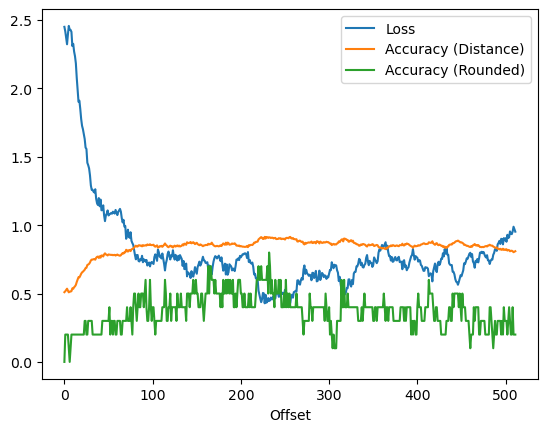

In [130]:
# This code was used to determine where to find the single best result from
# the prediction. It will be moved to the analsis notebook...

# Probably wrong for text decoding...

col_offset = []
col_loss = []
col_acc_dist = []
col_acc_round = []

# Looping through individual inputs is horribly slow, but I specifically wanted this
# so I could relate behaviors to what I could actually see.
HOW_MANY = 10
for _ in range(HOW_MANY):
    which_input = random.randint(0, input.shape[0]-1)
    this_input = input[which_input:which_input+1, :, :]
    this_expected = expected[which_input:which_input+1, :, :]

    raw_predicted = nn.predict(this_input, batch_size=BATCH_SIZE)
    this_predicted = raw_predicted.astype(np.float64)

    offsets = range(0, CHUNK_SIZE)
    #offsets = [0, CHUNK_SIZE//2, CHUNK_SIZE-1]

    for offset in offsets:
        #offset_predicted = this_predicted[:, offset, 0] #!!! Wrong for text. Can the last one just be colon?
        offset_predicted = this_predicted[:, offset, :]
        loss = modulo_distance_loss(this_expected, offset_predicted)
        accuracy_distance = modulo_distance_accuracy(this_expected, offset_predicted)
        accuracy_rounded = modulo_rounded_accuracy(this_expected, offset_predicted)

        col_offset.append(offset)
        col_loss.append(loss.numpy())
        col_acc_dist.append(accuracy_distance.numpy())
        col_acc_round.append(accuracy_rounded.numpy())

metrics_df = pd.DataFrame({
    "Offset": col_offset,
    "Loss": col_loss,
    "Accuracy (Distance)": col_acc_dist,
    "Accuracy (Rounded)": col_acc_round 
}).set_index("Offset")

metrics_df = metrics_df.groupby(['Offset']).mean()
print(metrics_df.describe())
metrics_df.plot()

# Model Usefulness Spot-Check

In [131]:
# These functions assume Caesar cipher, and need to be updated after shape change
class Caesar_Cracker(object):
    def __init__(self, chunk_size, scaler, key_model, text_model):
        self.chunk_size = chunk_size
        self.scaler = scaler
        self.key_model = key_model
        self.text_model = text_model

        if (key_model is not None) and (key_model.input_shape[2] != chunk_size):
            raise Exception(f"Input size mismatch. Key model expects {key_model.input_shape}, chunk size is {chunk_size}")

    def infer_text_with_model(self, ciphertext: str) -> str:
        offsets = encoders.string_to_offsets(ciphertext)
        chunks = helpers.chunkify(offsets, self.chunk_size)
        scaled_chunks = self.scaler.transform(chunks)
        shaped_chunks = tf_helpers.reshape_input(np.array(scaled_chunks), self.chunk_size)
        guesses = self.text_model.predict(shaped_chunks, verbose=0)
        # Shape of prediction:
        # (chunk count, chunk size, chunk size)
        # ... so that's a little confusing. For keys, the 2nd dimension corresponds to time,
        # so get the final (best?) guesses
        best_guesses = guesses[:, self.chunk_size-1, :]

        # Now we have floating point offsets. We want integer offsets, then strings:
        flat = best_guesses.flatten()        
        int_offsets = flat.round().astype(int)
        result = encoders.offsets_to_string(int_offsets)

        return result

    def infer_key_with_model(self, ciphertext: str) -> int:
        offsets = encoders.string_to_offsets(ciphertext)
        chunks = helpers.chunkify(offsets, self.chunk_size)
        scaled_chunks = self.scaler.transform(chunks)
        shaped_chunks = tf_helpers.reshape_input(np.array(scaled_chunks), self.chunk_size)
        keys = self.key_model.predict(shaped_chunks, verbose=0)
        # Shape of keys:
        # (chunk count, chunk size, 1)

        # The model puts out a key for every iteration through the data, and (on average)
        # gets more accurate every time, so the best key is the last one:
        best_keys = keys[:, self.chunk_size-1, :]

        # We have the best key from each chunk, so pick the middle one:
        key = np.median(best_keys)
        return int(round(key))

FILES_TO_CHECK = 3
if INFER_TEXT:    
    CHUNKS_TO_CHECK = 1
else:
    CHUNKS_TO_CHECK = 20

good=0
bad=0
for _ in range(FILES_TO_CHECK):
    sid = random.choice(list(sid_to_c.keys()))
    cipher_file_db = random.choice(sid_to_c[sid])
    ciphertext_path = cipher_file_db.path
    ciphertext = helpers.read_text_file(ciphertext_path)
    length = min(CHUNK_SIZE * CHUNKS_TO_CHECK, len(ciphertext))
    ciphertext = ciphertext[0:length]
    
    if INFER_KEY:
        cracker = Caesar_Cracker(CHUNK_SIZE, X_scaler, nn, None)
    
        with db.get_session() as session:
            correct_key = int(db.get_key_by_id(session, cipher_file_db.key_id).value)
        
        inferred_key = cracker.infer_key_with_model(ciphertext)

        if correct_key == inferred_key:
            good += 1
        else:
            bad += 1
    if INFER_TEXT:
        cracker = Caesar_Cracker(CHUNK_SIZE, X_scaler, None, nn)
    
        with db.get_session() as session:
            correct_key = int(db.get_key_by_id(session, cipher_file_db.key_id).value)
            
        inferred_text = cracker.infer_text_with_model(ciphertext)
        #!!! print(ciphertext[0:128])
        #!!! print(inferred_text[0:128])
        #!!! print()

        if True:
            # Checking distribution
            offsets = encoders.string_to_offsets(ciphertext)
            chunks = helpers.chunkify(offsets, cracker.chunk_size)
            scaled_chunks = cracker.scaler.transform(chunks)
            shaped_chunks = tf_helpers.reshape_input(np.array(scaled_chunks), cracker.chunk_size)
            guesses = cracker.text_model.predict(shaped_chunks, verbose=0)
            best_guesses = guesses[:, cracker.chunk_size-1, :]
            flat = best_guesses.flatten()        
            int_offsets = flat.round().astype(int)

            print(pd.Series(int_offsets).value_counts())

if bad > 0:
    print(good, bad, float(good)/float(bad))

2 1 2.0
